In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from scipy import misc
import math
from tqdm import tqdm

In [2]:
def show_diff(i):
    plt.imshow(abs(X[i]))
    
def show_source(i):
    plt.imshow(np.ones(X[i].shape) + X[i])
    
def to_255_color(x):
    return x * 255

def to_image_size(x):
    return x * 100

def to_180_rotation(x):
    return (x - 0.5) * 360
    
def print_scaled_y(y):
    if len(y) == 9:
        print("RGBA = (%d, %d, %d, %d), lewy górny róg = (%d, %d), w = %d, h = %d, rotation = %d" 
          % (to_255_color(y[0]), to_255_color(y[1]), to_255_color(y[2]), y[3] * 100, to_image_size(y[4]),
             to_image_size(y[5]), to_image_size(y[6]), to_image_size(y[7]), to_180_rotation(y[8])))
    elif len(y) == 10:
        print("RGBA = (%d, %d, %d, %d), A = (%d, %d), B = (%d, %d), C = (%d, %d)" 
          % (to_255_color(y[0]), to_255_color(y[1]), to_255_color(y[2]), y[3] * 100, to_image_size(y[4]),
             to_image_size(y[5]), to_image_size(y[6]), to_image_size(y[7]), to_image_size(y[8]), to_image_size(y[9])))
        
def print_scaled_line_y(y):
    print("RGBA = (%d, %d, %d, %d), A = (%d, %d), B = (%d, %d), size = %d" 
          % (to_255_color(y[0]), to_255_color(y[1]), to_255_color(y[2]), y[3] * 100, to_image_size(y[4]),
             to_image_size(y[5]), to_image_size(y[6]), to_image_size(y[7]), to_image_size(y[8])))

In [3]:
from src.gimp.draw.draw_triangle import draw_triangle as _draw_triangle
from src.gimp.draw.draw_line import draw_line as _draw_line
import os

def draw(y_, shape):
    path_to_image_results = '../result/gimp_images/nn/shapes'
    name = 'jupyter_test.png'
    os.system('python ../src/gimp/draw/draw_selection_shape.py --name {} --shape {} --size {} --r {} --g {} --b {} --a {} --x {} --y {} --w {} --h {} --rotation {}'\
              .format(name, shape, 100, y_[0], y_[1], y_[2], y_[3], y_[4], y_[5], y_[6], y_[7], y_[8]))
    image_data = plt.imread('%s/%s' % (path_to_image_results, name))[:,:,:3]
    plt.imshow(image_data)
    
def draw_rectangle(y):
    draw(y, 'rectangle')
    
def draw_ellipse(y):
    draw(y, 'ellipse')
    
def draw_triangle(y):
    path_to_image_results = '../result/gimp_images/nn/shapes'
    name = 'jupyter_test.png'
    _draw_triangle(name, 100, y[0], y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9])
    image_data = plt.imread('%s/%s' % (path_to_image_results, name))[:,:,:3]
    plt.imshow(image_data)
    
def draw_line(y):
    path_to_image_results = '../result/gimp_images/nn/shapes'
    name = 'jupyter_test.png'
    _draw_line(name, 100, y[0], y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8])
    image_data = plt.imread('%s/%s' % (path_to_image_results, name))[:,:,:3]
    plt.imshow(image_data)

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.python.tools import inspect_checkpoint as chkp

class ConvNetwork(object):
    def __init__(self, model_path):
        self.model_path = model_path
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.sess = tf.Session(graph=self.graph)
            saver = tf.train.import_meta_graph(model_path + ".meta")
            saver.restore(self.sess, model_path)

        self.y_conv = self.graph.get_tensor_by_name("fc2/y_conv:0")
        self.y = self.graph.get_tensor_by_name("y:0")
        self.x = self.graph.get_tensor_by_name("x:0")
        self.keep_prob = self.graph.get_tensor_by_name("dropout/keep_prob:0")
        self.loss = self.graph.get_tensor_by_name("loss/loss:0")

    def generate_args(self, x):
        return self.sess.run(self.y_conv, feed_dict={self.x: np.expand_dims(x, 0), self.keep_prob: 1.0})[0]

    def eval_error(self, X, Y):
        return self.loss.eval(session=self.sess, feed_dict={self.x: X, self.y: Y, self.keep_prob: 1.0})

    def print_tensors(self):
        chkp.print_tensors_in_checkpoint_file(self.model_path, tensor_name='', all_tensors=True)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def eval_mse():
    batch_size = 10
    num_batches = len(X) // batch_size
    mse = []
    for i in tqdm(range(num_batches)):
        start = i * batch_size
        end = start + batch_size
        mse.append(cnn.eval_error(X[start:end], Y[start:end]))
    print(np.mean(np.array(mse)))

# Prostokąt
### Dane

In [7]:
name = "train"
path = "../data/dataset/random_rectangle/"
X = np.load(path + "%s_X.npy" % name, mmap_mode="r")
Y = np.load(path + "%s_Y.npy" % name, mmap_mode="r")

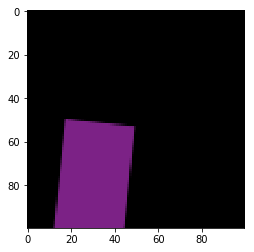

In [17]:
index = np.random.randint(0, X.shape[0])
show_diff(index)

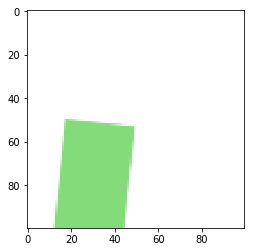

In [18]:
show_source(index)

In [19]:
print_scaled_y(Y[index])

RGBA = (69, 203, 54, 66), lewy górny róg = (1, 65), w = 59, h = 32, rotation = -102


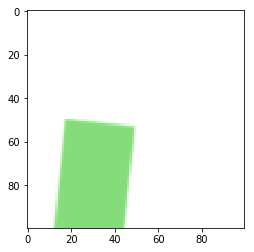

In [20]:
draw_rectangle(Y[index])

### Model
--conv1_filters 46 --conv2_filters 36 --fc1_neurons 510 --learning_rate 0.000759552942112 --dropout 0.483347552411  --loss_sigmoid --batch_size 153

In [23]:
model_path = "../result/model/rectangle/rectangle-23"
cnn = ConvNetwork(model_path)

INFO:tensorflow:Restoring parameters from ../result/model/rectangle/rectangle-75


In [26]:
name = "test"
path = "../data/dataset/random_rectangle/"
X = np.load(path + "%s_X.npy" % name, mmap_mode="r")
Y = np.load(path + "%s_Y.npy" % name, mmap_mode="r")

In [27]:
eval_mse()

100%|██████████| 150/150 [04:12<00:00,  1.85s/it]

0.03465049


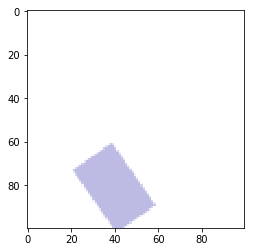

In [33]:
index = np.random.randint(0, X.shape[0])
show_source(index)

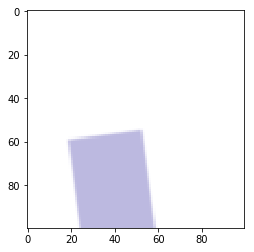

In [34]:
y = cnn.generate_args(X[index])
draw_rectangle(sigmoid(y))

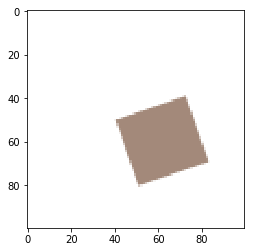

In [35]:
index = np.random.randint(0, X.shape[0])
show_source(index)

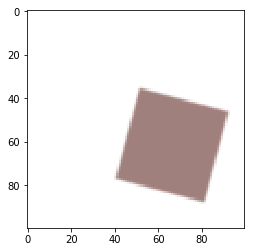

In [36]:
y = cnn.generate_args(X[index])
draw_rectangle(sigmoid(y))

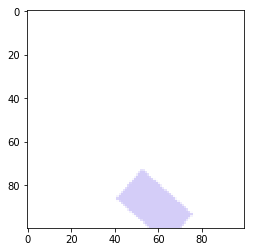

In [37]:
index = np.random.randint(0, X.shape[0])
show_source(index)

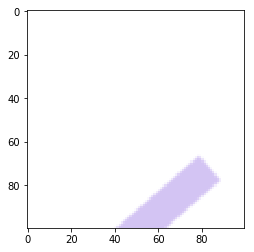

In [38]:
y = cnn.generate_args(X[index])
draw_rectangle(sigmoid(y))

Wnioski: mse 0.03 to zdecydowanie za duży błąd. Kolor wychodzi całkiem spoko, pozycja na obrazku mniej więcej tam gdzie trzeba, rotacja i wymiary kształtu raczej słabo. Może większy dataset i przeszukanie większej ilości hiperparametrów?

## 3 warstwy konwolucyjne
### Model
--conv1_filters 32 --conv2_filters 51 --conv3_filters 80 --fc1_neurons 392 --learning_rate 0.000941519413108 --dropout 0.43321066423 --batch_size 72 --fc2_sigmoid

In [40]:
model_path = "../result/model/square/rectangle/rectangle-19"
cnn = ConvNetwork(model_path)
name = "test"
path = "../data/dataset/random_rectangle/"
X = np.load(path + "%s_X.npy" % name, mmap_mode="r")
Y = np.load(path + "%s_Y.npy" % name, mmap_mode="r")
eval_mse()
index = np.random.randint(0, X.shape[0])
show_source(index)

OSError: File ../result/model/square/rectangle/rectangle-19.meta does not exist.

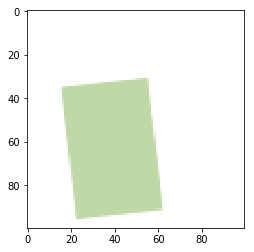

In [8]:
y = cnn.generate_args(X[index])
draw_rectangle(y)

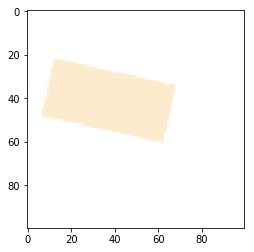

In [13]:
index = np.random.randint(0, X.shape[0])
show_source(index)

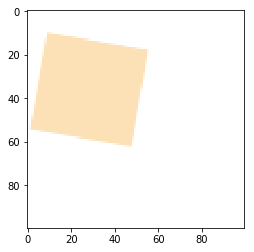

In [14]:
y = cnn.generate_args(X[index])
draw_rectangle(y)

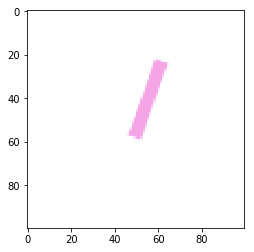

In [18]:
index = np.random.randint(0, X.shape[0])
show_source(index)

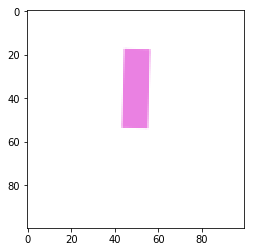

In [19]:
y = cnn.generate_args(X[index])
draw_rectangle(y)

# Elipsa
### Dane

In [41]:
name = "train"
path = "../data/dataset/random_ellipse/"
X = np.load(path + "%s_X.npy" % name, mmap_mode="r")
Y = np.load(path + "%s_Y.npy" % name, mmap_mode="r")

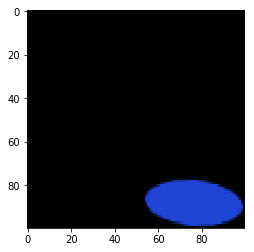

In [42]:
index = np.random.randint(0, X.shape[0])
show_diff(index)

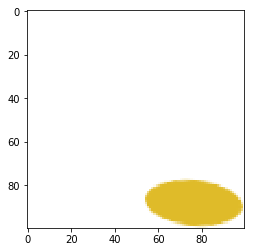

In [43]:
show_source(index)

In [44]:
print_scaled_y(Y[index])

RGBA = (222, 183, 29, 94), lewy górny róg = (54, 78), w = 45, h = 21, rotation = -135


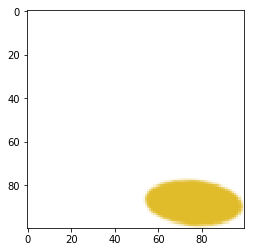

In [45]:
draw_ellipse(Y[index])

### Model
--conv1_filters 46 --conv2_filters 36 --fc1_neurons 510 --learning_rate 0.000759552942112 --dropout 0.483347552411  --loss_sigmoid --batch_size 50

In [48]:
model_path = "../result/model/ellipse/ellipse-8"
cnn = ConvNetwork(model_path)

INFO:tensorflow:Restoring parameters from ../result/model/ellipse/ellipse-8


In [49]:
name = "test"
path = "../data/dataset/random_ellipse/"
X = np.load(path + "%s_X.npy" % name, mmap_mode="r")
Y = np.load(path + "%s_Y.npy" % name, mmap_mode="r")

In [12]:
eval_mse()

100%|██████████| 150/150 [00:33<00:00,  4.50it/s]

0.03321274


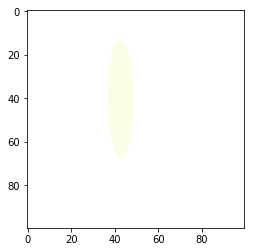

In [50]:
index = np.random.randint(0, X.shape[0])
show_source(index)

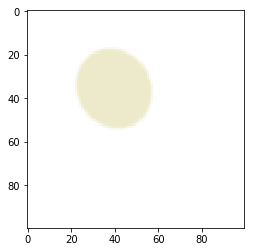

In [51]:
y = cnn.generate_args(X[index])
draw_ellipse(sigmoid(y))

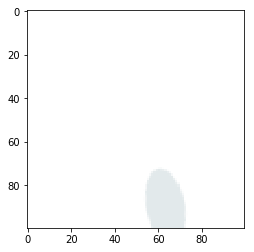

In [52]:
index = np.random.randint(0, X.shape[0])
show_source(index)

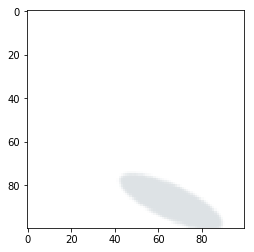

In [53]:
y = cnn.generate_args(X[index])
draw_ellipse(sigmoid(y))

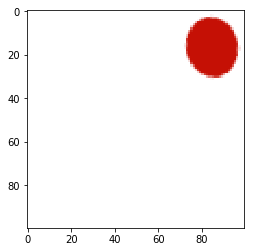

In [56]:
index = np.random.randint(0, X.shape[0])
show_source(index)

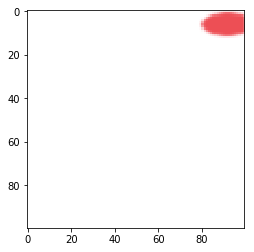

In [57]:
y = cnn.generate_args(X[index])
draw_ellipse(sigmoid(y))

# Trójkąt
### Dane

In [58]:
name = "train"
path = "../data/dataset/random_triangle/"
X = np.load(path + "%s_X.npy" % name, mmap_mode="r")
Y = np.load(path + "%s_Y.npy" % name, mmap_mode="r")

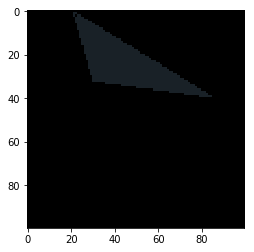

In [59]:
index = np.random.randint(0, X.shape[0])
show_diff(index)

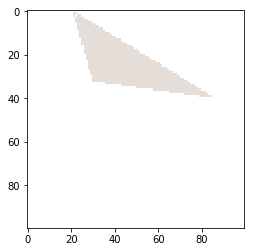

In [60]:
show_source(index)

In [61]:
print_scaled_y(Y[index])

RGBA = (189, 168, 155, 38), A = (30, 32), B = (84, 39), C = (21, 0)


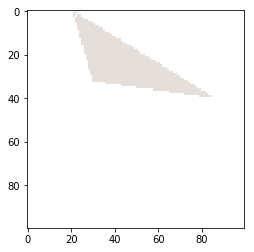

In [64]:
draw_triangle(Y[index])

### Model
--conv1_filters 46 --conv2_filters 36 --fc1_neurons 510 --learning_rate 0.000759552942112 --dropout 0.483347552411  --loss_sigmoid --batch_size 50

INFO:tensorflow:Restoring parameters from ../result/model/triangle/triangle-8


100%|██████████| 150/150 [02:12<00:00,  1.12it/s]

0.051675268


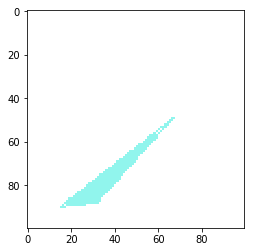

In [66]:
model_path = "../result/model/triangle/triangle-8"
cnn = ConvNetwork(model_path)
name = "test"
path = "../data/dataset/random_triangle/"
X = np.load(path + "%s_X.npy" % name, mmap_mode="r")
Y = np.load(path + "%s_Y.npy" % name, mmap_mode="r")
eval_mse()
index = np.random.randint(0, X.shape[0])
show_source(index)

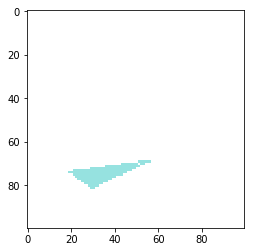

In [67]:
y = cnn.generate_args(X[index])
draw_triangle(sigmoid(y))

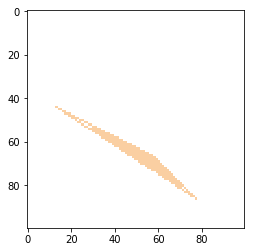

In [68]:
index = np.random.randint(0, X.shape[0])
show_source(index)

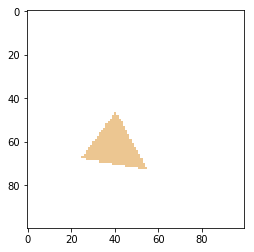

In [69]:
y = cnn.generate_args(X[index])
draw_triangle(sigmoid(y))

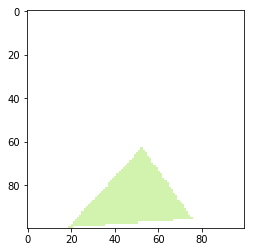

In [70]:
index = np.random.randint(0, X.shape[0])
show_source(index)

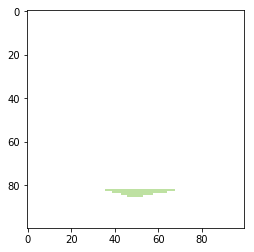

In [71]:
y = cnn.generate_args(X[index])
draw_triangle(sigmoid(y))

Z trójkątami idzie trochę gorzej. Pewnie między innymi dlatego, że mają więcej parametrów.

# Linia
### Dane

In [72]:
name = "train"
path = "../data/dataset/random_line/"
X = np.load(path + "%s_X.npy" % name, mmap_mode="r")
Y = np.load(path + "%s_Y.npy" % name, mmap_mode="r")

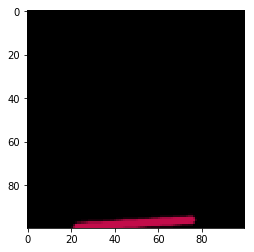

In [73]:
index = np.random.randint(0, X.shape[0])
show_diff(index)

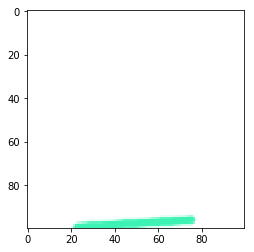

In [74]:
show_source(index)

In [75]:
print_scaled_line_y(Y[index])

RGBA = (60, 243, 180, 99), A = (75, 96), B = (22, 99), size = 3


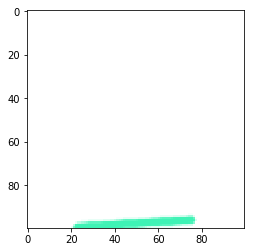

In [76]:
draw_line(Y[index])

### Model
--conv1_filters 46 --conv2_filters 36 --fc1_neurons 510 --learning_rate 0.000759552942112 --dropout 0.483347552411  --loss_sigmoid --batch_size 50

INFO:tensorflow:Restoring parameters from ../result/model/line/line-6


100%|██████████| 150/150 [02:26<00:00,  1.03s/it]


0.037827346


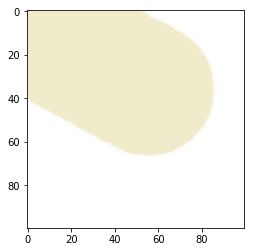

In [78]:
model_path = "../result/model/line/line-6"
cnn = ConvNetwork(model_path)
name = "test"
path = "../data/dataset/random_line/"
X = np.load(path + "%s_X.npy" % name, mmap_mode="r")
Y = np.load(path + "%s_Y.npy" % name, mmap_mode="r")
eval_mse()
index = np.random.randint(0, X.shape[0])
show_source(index)

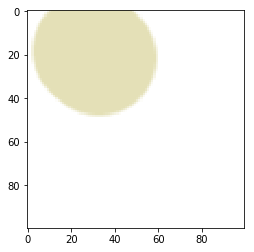

In [79]:
y = cnn.generate_args(X[index])
draw_line(sigmoid(y))

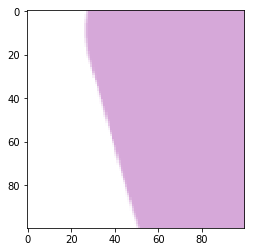

In [80]:
index = np.random.randint(0, X.shape[0])
show_source(index)

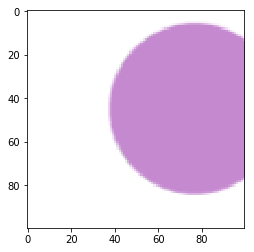

In [81]:
y = cnn.generate_args(X[index])
draw_line(sigmoid(y))

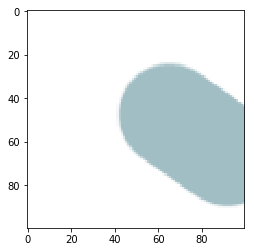

In [82]:
index = np.random.randint(0, X.shape[0])
show_source(index)

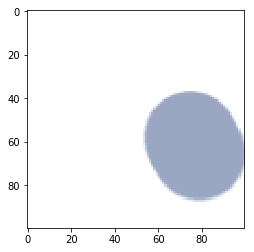

In [83]:
y = cnn.generate_args(X[index])
draw_line(sigmoid(y))